In [1]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Pregunta 1
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression

# Pregunta 2
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interact,fixed

%matplotlib inline

Using TensorFlow backend.


# Pregunta 1

In [2]:
"""
Función para crear el conjunto de datos, con una clase dentro de la otra.
"""
def do_circles(n=2000,noisy_n=0.05):
    generator = check_random_state(10)
    linspace = np.linspace(0, 2 * np.pi, n // 2 + 1)[:-1]
    outer_circ_x = np.cos(linspace)
    outer_circ_y = np.sin(linspace)

    inner_circ_x = outer_circ_x * .3
    inner_circ_y = outer_circ_y * .3
    X = np.vstack((np.append(outer_circ_x, inner_circ_x),
        np.append(outer_circ_y, inner_circ_y))).T
    y = np.hstack([np.zeros(n // 2, dtype=np.intp),
        np.ones(n // 2, dtype=np.intp)])
    X += generator.normal(scale=noisy_n, size=X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.5, random_state=42)
    return X_train,y_train,X_test,y_test

In [3]:
#Creando los datos
X_train, Y_train,X_test,Y_test= do_circles()

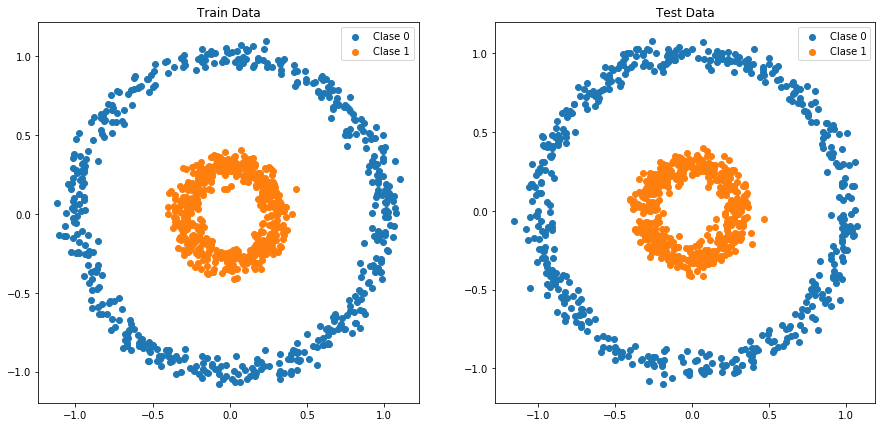

In [4]:
def plot_data(X_train,Y_train, X_test,Y_test):
    #Ploteando los datos
    fig,ax = plt.subplots(1,2,figsize=(15,7))
    ax[0].scatter(X_train[Y_train == 0,0],X_train[Y_train == 0,1],label="Clase 0")
    ax[0].scatter(X_train[Y_train == 1,0],X_train[Y_train == 1,1],label="Clase 1")
    ax[0].set_title("Train Data")
    ax[1].scatter(X_test[Y_test == 0,0],X_test[Y_test == 0,1],label="Clase 0")
    ax[1].scatter(X_test[Y_test == 1,0],X_test[Y_test == 1,1],label="Clase 1")
    ax[1].set_title("Test Data")
    ax[0].legend()
    ax[1].legend()
    plt.show()
plot_data(X_train,Y_train, X_test,Y_test)

Se observa que la data de train tienen la misma forma, este supuesto no siempre se cumple en problemas reales pero para la experimentación de esta tarea es un buen ejemplo.

Se observa que el dataset no es linealmente separable ya que no se puede dividir las dos clases con un híperplano separador, si no que tenemos que buscar una función no lineal que realice la separación entre las dos clases.

In [5]:
"""
Función utilizada graficar las fronteras de decisión de cada modelo
"""
def plot_classifier(clf,X_train,Y_train,X_test,Y_test,model_type):
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    f, ax = plt.subplots(1, 1,figsize=(9, 8))
    XX, YY = np.mgrid[-2:2:200j, -2:2:200j]
   
    if model_type == "ann": #hasattr(clf, "decision_function"):
        Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
    else:
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

    Z = Z.reshape(XX.shape) #> 0.5
    ax.contourf(XX, YY, Z, cmap=cm, alpha=.8)
    
    ax.scatter(X_train[:,0],X_train[:,1],c=Y_train, cmap=cm_bright,
                   edgecolors='k')
    ax.scatter(X_test[:,0],X_test[:,1],c=Y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.7)
    ax.set_xlim(XX.min(), XX.max())
    ax.set_ylim(YY.min(), YY.max())
    ax.set_xticks(())
    ax.set_yticks(())
    plt.show()

## Red Neuronales
### Una Neurona
Utilizando una red neuronal con una neurona en la capa oculta, variando ĺa función de activación.

34464/40000 [========================>.....] - ETA: 0s

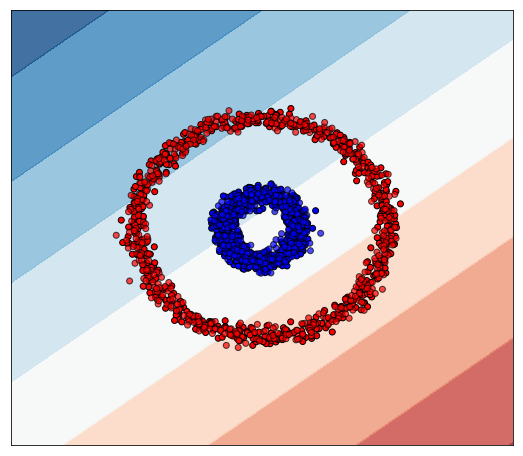

sigmoid : 0.583
37856/40000 [===========================>..] - ETA: 0s

/home/tronco/anaconda3/lib/python3.6/site-packages/keras/models.py:998: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


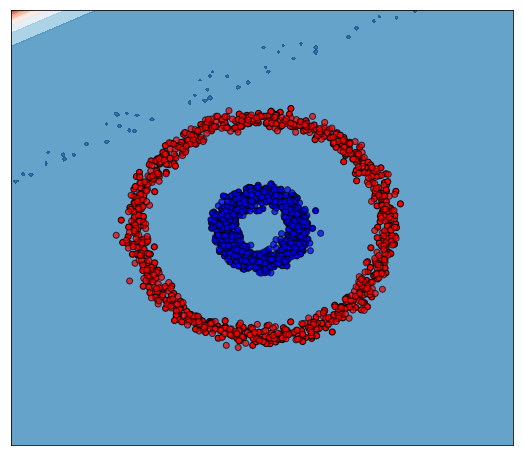

tanh : 0.493
39936/40000 [============================>.] - ETA: 0s

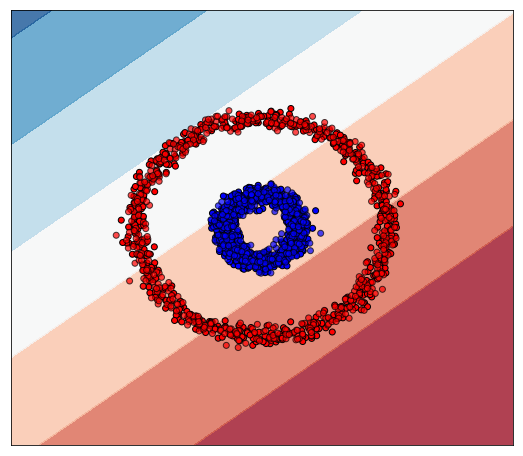

relu : 0.0


In [6]:
n_h=1
activation = "sigmoid"
for activation in ["sigmoid", "tanh","relu"]:
    np.random.seed(0)
    model = Sequential()
    model.add(Dense(n_h,input_dim=X_train.shape[1], activation=activation))
    model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, Y_train, epochs=100, batch_size=100, verbose=0)
    scores = model.evaluate(X_test, Y_test)
    test_acc = scores[1]
    plot_classifier(model,X_train,Y_train,X_test,Y_test,"ann")
    print(activation, ":",test_acc)

Se observa que utilizando sólo una neurona no se realiza una división no lineal de la data, si no que se busca un hiperplano separador de la data, al variar la función de activación se observan distintos hiperplanos pero ninguno que pueda resolver el problema

### Múltiples Neuronas
Como una neurona no puede resolver el problema es momento de analizar el comportamiento de de la Red Neuronal utilizando variando la cantidad de neuronas, por simplicidad no se cambia la función de activación ni los parámetros de Gradiente Descendente.

2
37184/40000 [==========================>...] - ETA: 0s

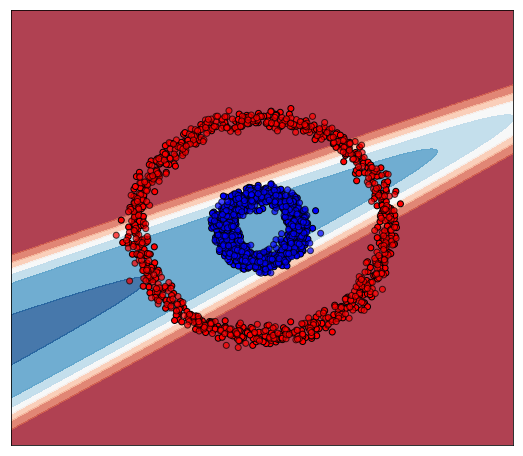

4
39456/40000 [============================>.] - ETA: 0s

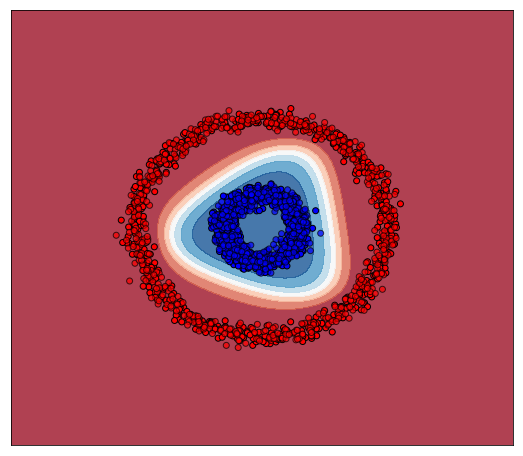

8
36480/40000 [==========================>...] - ETA: 0s

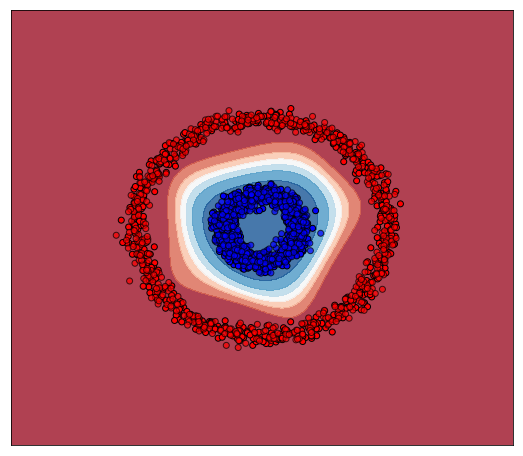

16
38528/40000 [===========================>..] - ETA: 0s

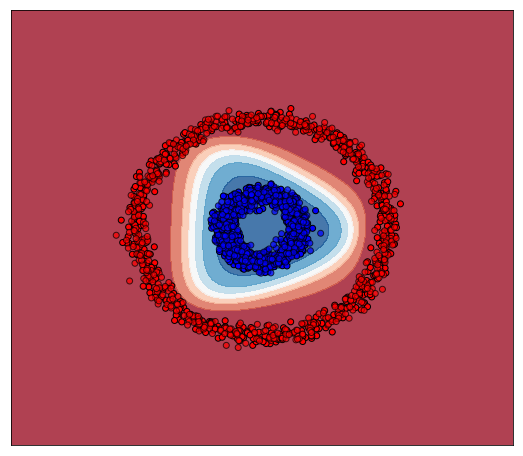

32
38752/40000 [============================>.] - ETA: 0s

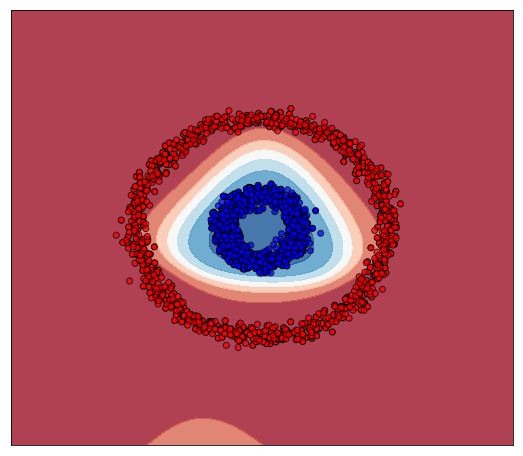

In [7]:
def multiple_neurons(X_train,Y_train, X_test,Y_test):
    acc_train = []
    acc_test = []

    activation = "sigmoid"
    n_hs = np.logspace(1,5,base=2,num=5,dtype=int)
    for n_h in n_hs:
        print(n_h)
        model = Sequential()
        model.add(Dense(n_h, input_dim=X_train.shape[1],activation=activation))    
        #Se agrega esta capa para tener la dimensión de output = 1 
        model.add(Dense(1, activation=activation))
        model.compile(optimizer=SGD(lr=1), loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, Y_train, epochs=100, batch_size=100, verbose=0)
        scores = model.evaluate(X_train, Y_train)
        train_acc = scores[1]
        acc_train.append(train_acc)

        scores = model.evaluate(X_test, Y_test)
        test_acc = scores[1]
        acc_test.append(test_acc)

        print("Accuracy:",test_acc)
        plot_classifier(model,X_train,Y_train,X_test,Y_test,"ann")
    return acc_train,acc_test
acc_train,acc_test = multiple_neurons(X_train,Y_train, X_test,Y_test)

Utilizando una mayor cantidad de neuronas se observa el comportamiento no lineal de las Redes Neuronales, se muestra que en el problema con un 5% de ruido es muy simple para una red neuronal hacer una buena clasificación ya que no existe un traslape entre las clases y estas están bien alejadas.

Sólo con 4 neuronas ya se obtiene un buen resultado para este problema que no es linealmente separable

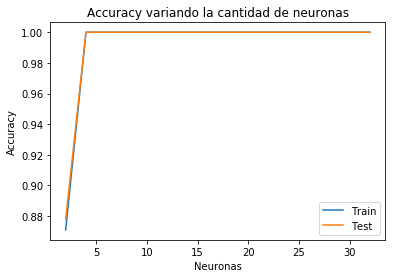

In [8]:
def plot_acc_multiple_neurons(acc_train,acc_test):
    n_hs = np.logspace(1,5,base=2,num=5,dtype=int)
    plt.plot(n_hs,acc_train, label="Train")
    plt.plot(n_hs, acc_test,label="Test")
    plt.title("Accuracy variando la cantidad de neuronas")
    plt.xlabel("Neuronas")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
plot_acc_multiple_neurons(acc_train,acc_test)

Analizando el gráfico de Train y Test Accuracy se observa que con más de 2 neuronas ya la división es perfecta y no se genera overfitting.

#### Agregando ruido al problema

En el caso anterior las clases estaban bien separadas entre sí, pero si uno agrega un poco más de ruido esta división se vuelve un poco más complicada ya que si tratamos de realizar una clasificación perfecta caemos en un problema de overfitting obteniendo una performance menor en el conjunto de pruebas.

In [9]:
#Creando los datos con ruido
X_train_noise, Y_train_noise,X_test_noise,Y_test_noise= do_circles(noisy_n=.3)

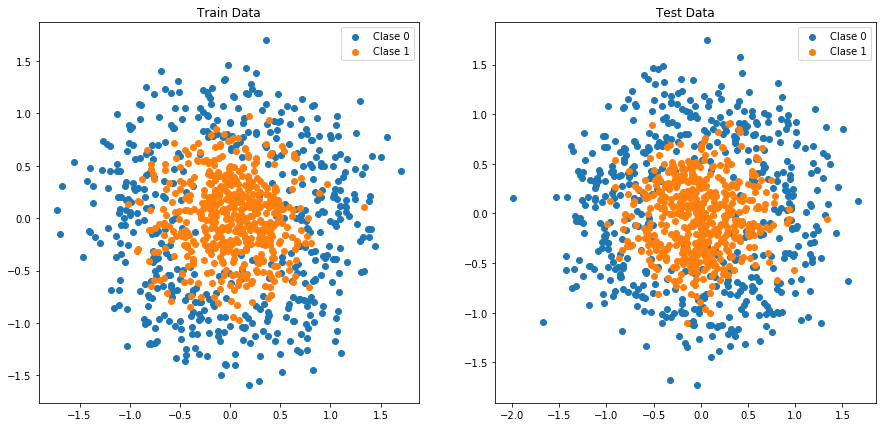

In [10]:
plot_data(X_train_noise,Y_train_noise, X_test_noise,Y_test_noise)

2
39520/40000 [============================>.] - ETA: 0s

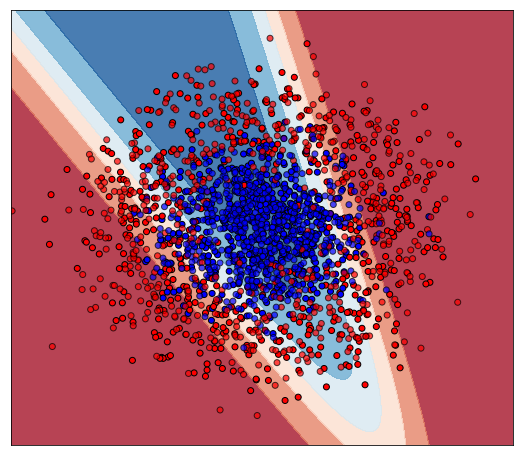

4
37248/40000 [==========================>...] - ETA: 0s

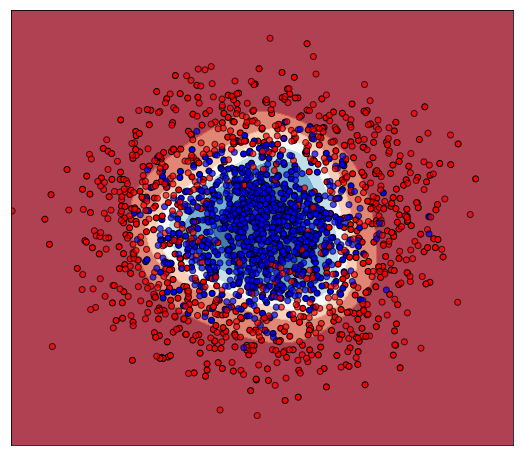

8
36768/40000 [==========================>...] - ETA: 0s

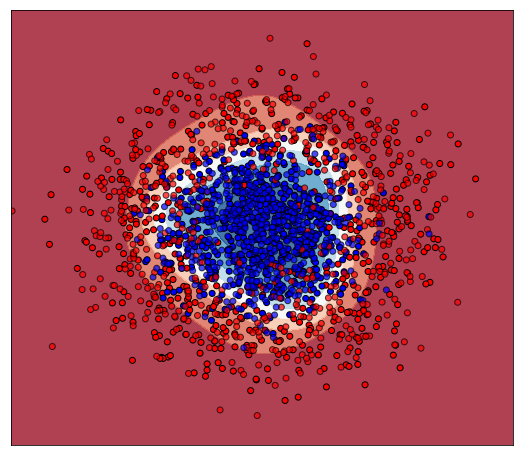

16
35520/40000 [=========================>....] - ETA: 0s

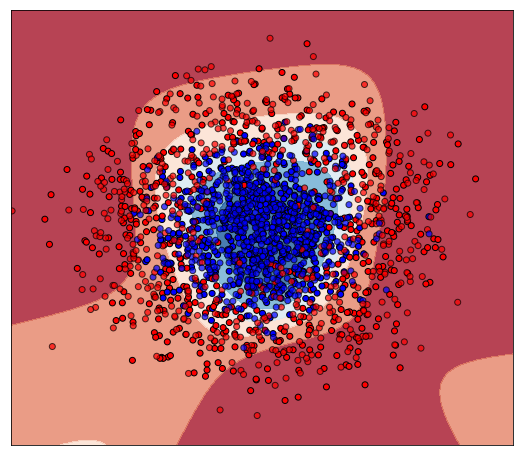

32
38528/40000 [===========================>..] - ETA: 0s

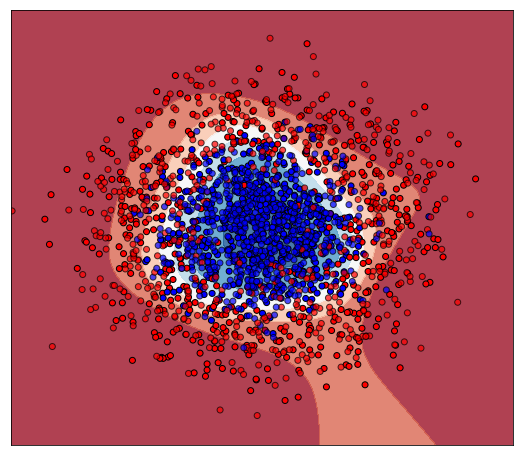

In [11]:
acc_train,acc_test = multiple_neurons(X_train_noise,Y_train_noise, X_test_noise,Y_test_noise)

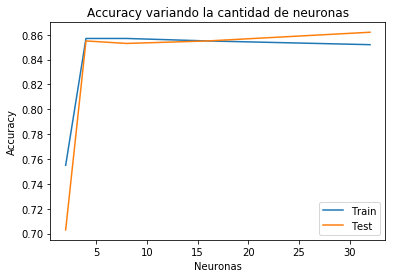

In [12]:
plot_acc_multiple_neurons(acc_train,acc_test)

Al igual que el caso anterior se observa un buen accuracy de parte de las Redes Neuronales, pero por causa del error no se obtiene un accuracy del 100%, si no que la la red trata de perder un poco de accuracy para no caer en overfitting.

En el gráfico de Accuracy en Train y Test se observa que no existe un gran overfitting, sólo en un punto se obtuvo (donde está el mejor resultado en Train) se tiene una gran distancia entre las dos curvas.

## Árboles de Clasificación 

A diferencia de las Redes Neuronales los árboles de clasificación son modelos no-parametricos, y no entregan la probabilidad de que un ejemplo pertenezca a una clase si no que entregan la clase de la hoja donde cae el ejemplo por lo mismo la frontera de decisión es mucho más estricta (se ve como una linea entre una clase y la otra y no como una gradiente de color que va cambiando)


Test Accuracy = 0.670000
1


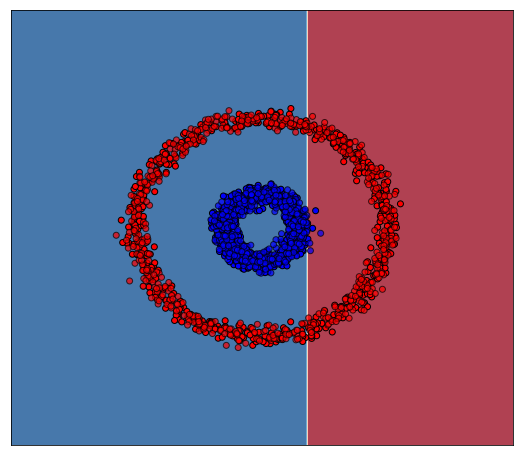

In [13]:
clf=DecisionTreeClassifier(criterion='gini',splitter='best',random_state=0,max_depth=1)
clf.fit(X_train,Y_train)
acc_test = clf.score(X_test,Y_test)
print("Test Accuracy = %f"%acc_test)
print(clf.tree_.max_depth)
plot_classifier(clf,X_train,Y_train,X_test,Y_test,"tree")

###  Variando la profundidad máxima
Al variar la profundidad máxima limitamos al árbol a realizar menos divisiones, por lo que obligamos a que algunas hojas queden menos "puras" o con ejemplos de otras clases, de esta forma evitamos que el modelo se ajuste demasiado a los datos y tenga mejor poder de generalización.

Max Depth: 4


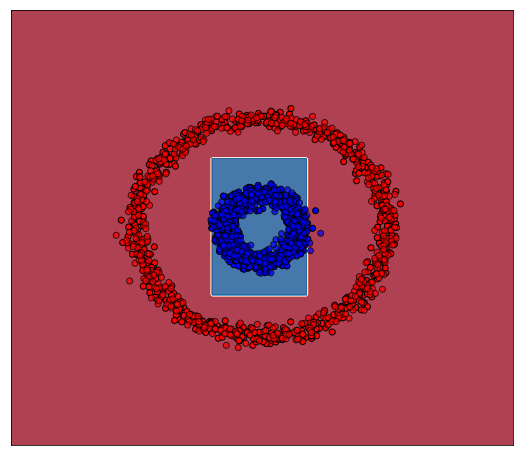

Max Depth: 8


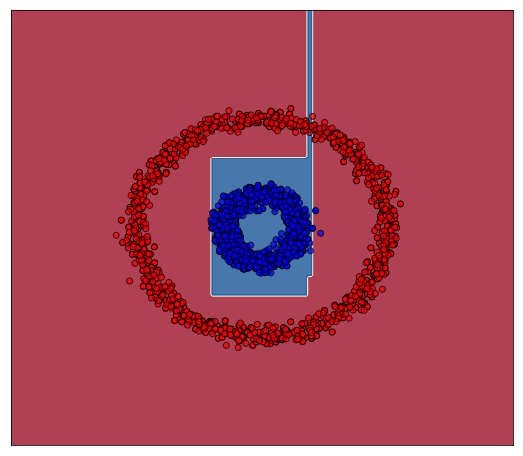

Max Depth: 12


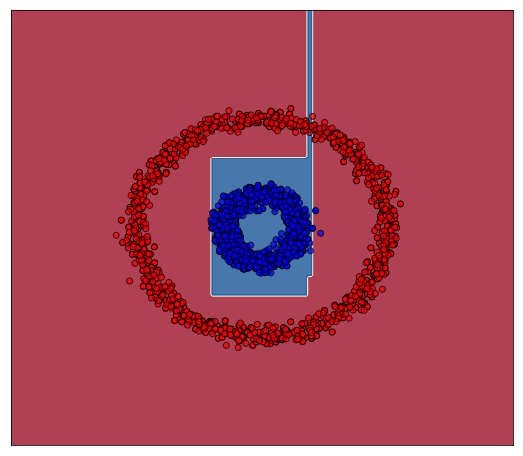

Max Depth: 16


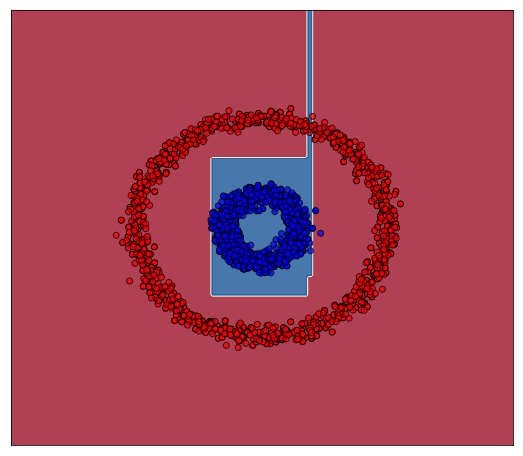

Max Depth: 20


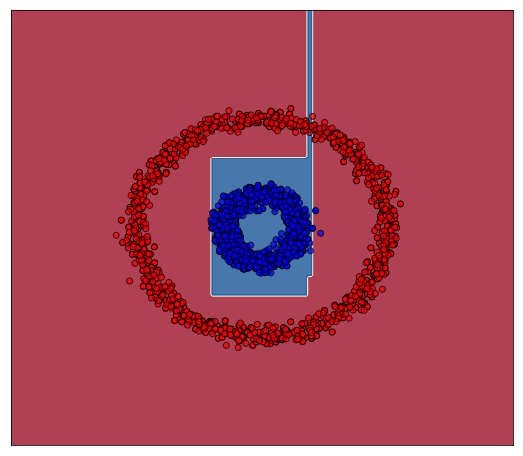

In [14]:
def multiple_depth(X_train,Y_train, X_test,Y_test):
    n_ts = list(range(2,22,2))
    acc_tests = []
    acc_trains = []
    for n_t in n_ts:
        clf=DecisionTreeClassifier(criterion='gini',splitter='best',random_state=0,max_depth=n_t)
        clf.fit(X_train,Y_train)
        acc_test = clf.score(X_test,Y_test)
        acc_train = clf.score(X_train,Y_train)
        if n_t % 4 == 0:
            print("Max Depth:", n_t)
            plot_classifier(clf,X_train,Y_train,X_test,Y_test,"tree")  
        acc_tests.append(acc_test)
        acc_trains.append(acc_train)
    return acc_tests,acc_trains
acc_tests,acc_trains = multiple_depth(X_train,Y_train, X_test,Y_test)

Al aumentar la profundidad máxima se observa que el modelo comienza a realizar mejores divisiones del dominio del problema, pero llega un punto donde se comienza a realizar sobre ajuste a los valores que se encuentran en el borde de la clase interior (los puntos que se ingresaron como ruido).

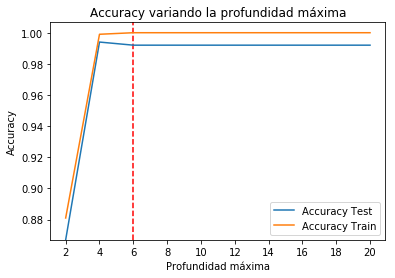

In [16]:
def plot_multiple_depths(acc_trains,acc_tests):
    n_ts = list(range(2,22,2))
    plt.axvline(n_ts[np.argmax(acc_trains)], color="red", ls="--")
    plt.plot(n_ts,acc_tests,label="Accuracy Test")
    plt.plot(n_ts,acc_trains,label="Accuracy Train")
    plt.xticks(n_ts,label="Max Train")
    plt.title("Accuracy variando la profundidad máxima")
    plt.ylim(bottom=np.min(acc_tests))
    plt.xlabel("Profundidad máxima")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
plot_multiple_depths(acc_trains,acc_tests)

Al observar el gráfico de Accuracy variando la profundidad máxima se observa que el modelo llega a un punto donde se comienza a generar overfitting ya que le "cree" mucho a los datos que contienen ruido.

### Aumentando la cantidad de ruido 

Max Depth: 4


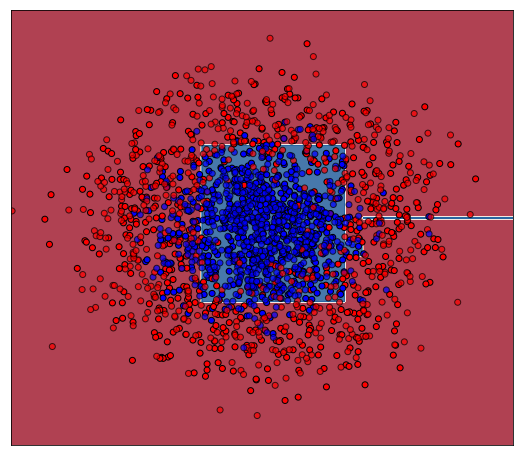

Max Depth: 8


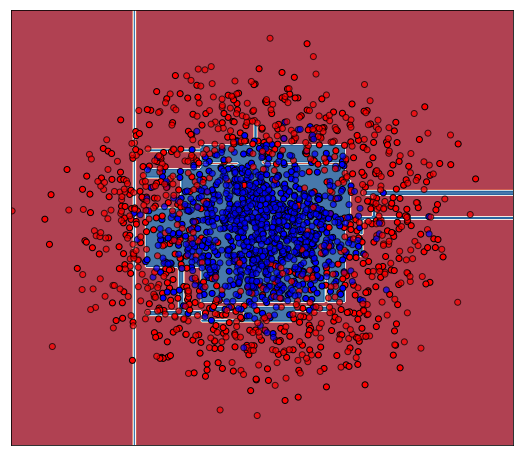

Max Depth: 12


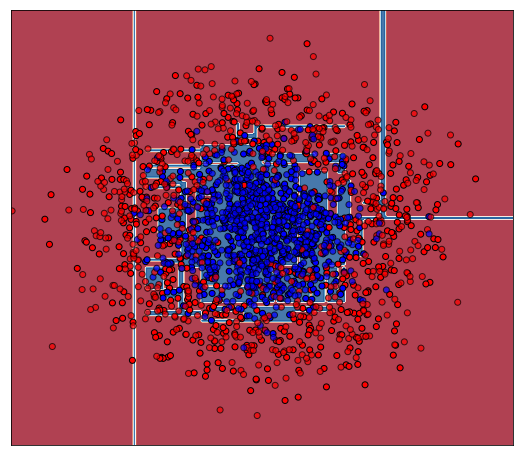

Max Depth: 16


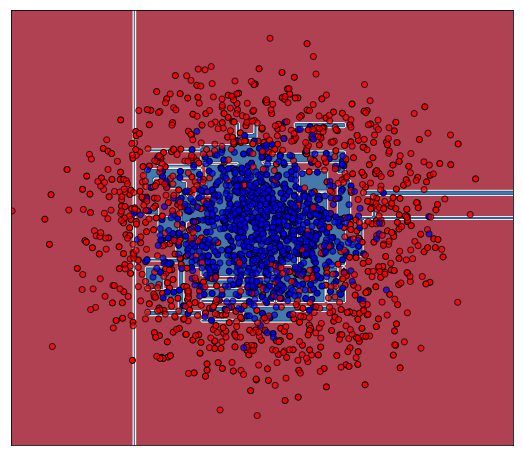

Max Depth: 20


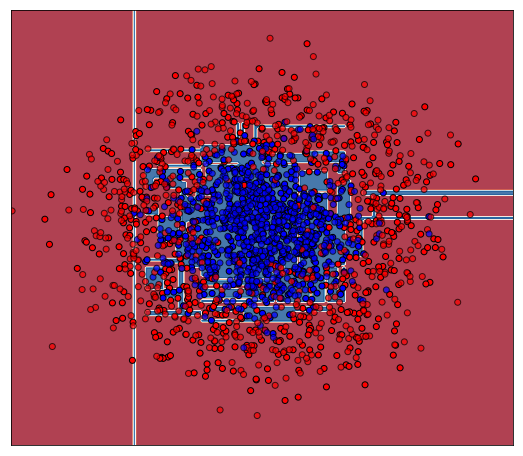

In [17]:
acc_tests,acc_trains = multiple_depth(X_train_noise,Y_train_noise, X_test_noise,Y_test_noise)

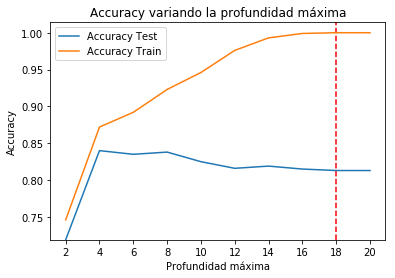

In [18]:
plot_multiple_depths(acc_trains,acc_tests)

Al aumentar la cantidad de ruido se observa el problema de overfitting en mayor medida, se observa que las fronteras de decisión del modelo estan muy afectadas por el ruido y en el gráfico de Accuracy observamos que mientras va aumentando el Accuracy de Train, el de Testing disminuye.

En estos casos es mejor utilizar cross validation para obtener la profundidad máxima que realize el menor overfitting.

## Manifold (KernelPCA)
Luego de experimentar con los distintos modelos en el dominio del problema, puede ser útil realizar preprocesamiento a los datos por ejemplo llevarlos a otro espacio donde puede ser que sea más fácil realizar la separación, en este caso se utilizará KernelPCA con un Kernel de función de radio basal.

In [19]:
kpca = KernelPCA(n_components=2,kernel="rbf", gamma=5)
kpca = kpca.fit(X_train)
Xkpca_train = kpca.transform(X_train)
Xkpca_test = kpca.transform(X_test)

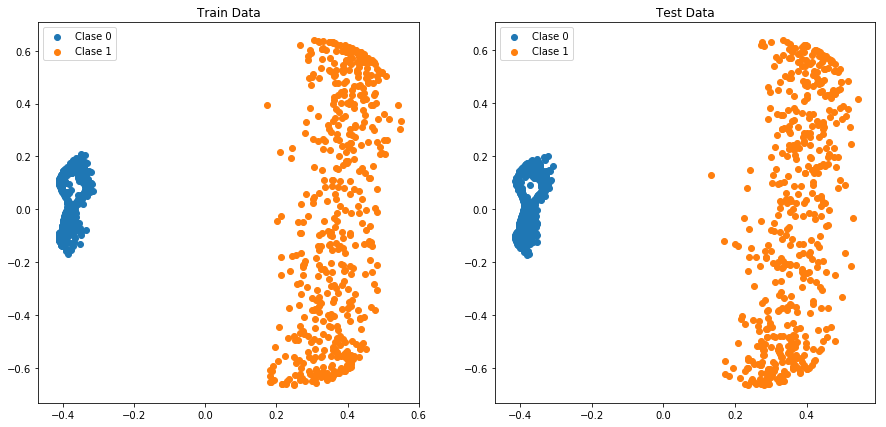

In [20]:
plot_data(Xkpca_train,Y_train, Xkpca_test, Y_test)

Luego de realizar la transformación del dominio se observa que los datos son linealmente separables por lo que todos los algoritmos van a poder realizar la separación

### Utilizando Stump

Test Accuracy = 1.000000
1


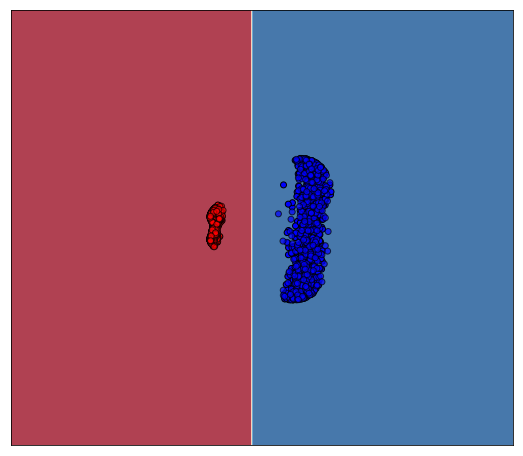

In [23]:
clf=DecisionTreeClassifier(criterion='gini',splitter='best',random_state=0,max_depth=1)
clf.fit(Xkpca_train,Y_train)
acc_test = clf.score(Xkpca_test,Y_test)
print("Test Accuracy = %f"%acc_test)
print(clf.tree_.max_depth)
plot_classifier(clf,Xkpca_train,Y_train,Xkpca_test,Y_test,"tree")

### Utilizando Logistic Regression

Test Accuracy = 1.000000


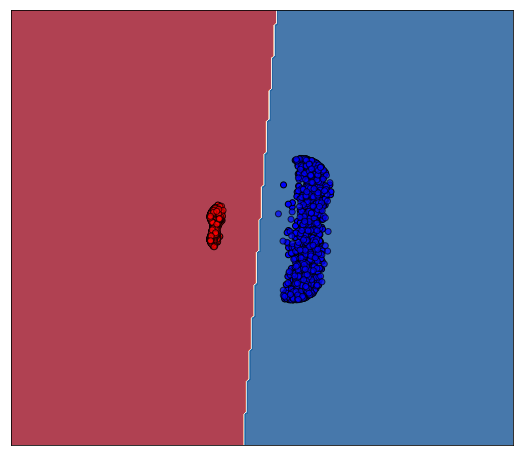

In [27]:
clf = LogisticRegression()
clf.fit(Xkpca_train,Y_train)

acc_test = clf.score(Xkpca_test,Y_test)
print("Test Accuracy = %f"%acc_test)
plot_classifier(clf,Xkpca_train,Y_train,Xkpca_test,Y_test,"tree")

Como era de esperarse al igual que en el stump que realiza un corte en el dominio (en forma de un hiperplano separador) un modelo lineal puede separar este problema en el nuevo espacio con un accuracy del 100%.

El problema se vuelve más complejo cuando hay mayor cantidad de ruido

In [30]:
kpca = KernelPCA(n_components=2,kernel="rbf", gamma=5)
kpca = kpca.fit(X_train_noise)
Xkpca_train_noise = kpca.transform(X_train_noise)
Xkpca_test_noise = kpca.transform(X_test_noise)

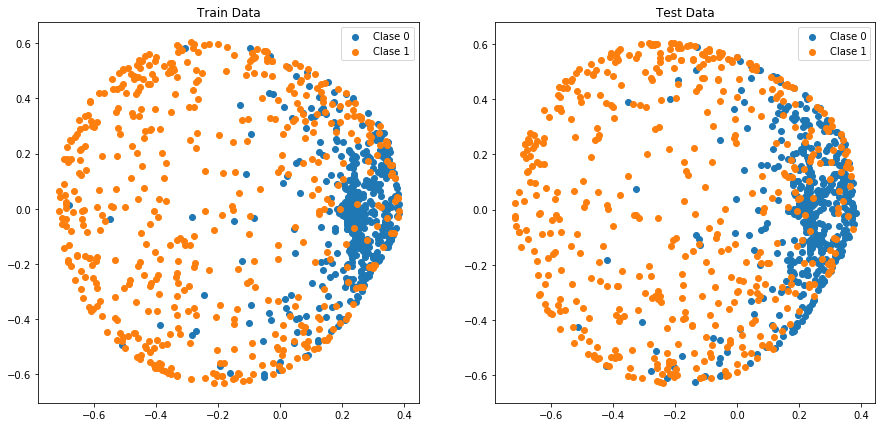

In [31]:
plot_data(Xkpca_train_noise,Y_train_noise, Xkpca_test_noise, Y_test_noise)

Con mayor cantidad de ruido al utilizar Kernel PCA no se ve tan linealmente separable como el problema anterior porque hay una gran cantidad de ruido en el sector de la clase 0, pero igual se puede separar tratando de dejar toda la clase 0 en un sector del plano

### Utilizando Stump

Test Accuracy = 0.826000
1


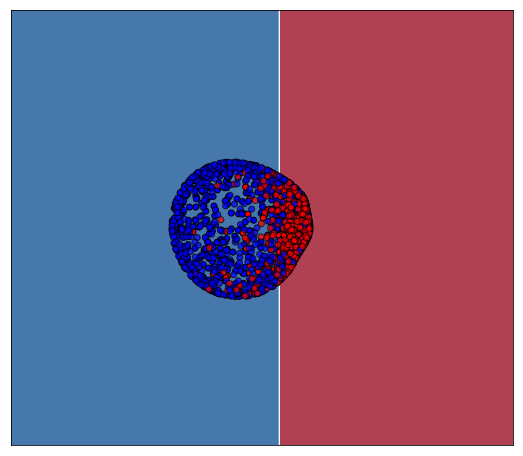

In [32]:
clf=DecisionTreeClassifier(criterion='gini',splitter='best',random_state=0,max_depth=1)
clf.fit(Xkpca_train_noise,Y_train_noise)
acc_test = clf.score(Xkpca_test_noise,Y_test_noise)
print("Test Accuracy = %f"%acc_test)
print(clf.tree_.max_depth)
plot_classifier(clf,Xkpca_train_noise,Y_train_noise,Xkpca_test_noise,Y_test_noise,"tree")

### Utilizando Logistic Regression

Test Accuracy = 0.820000


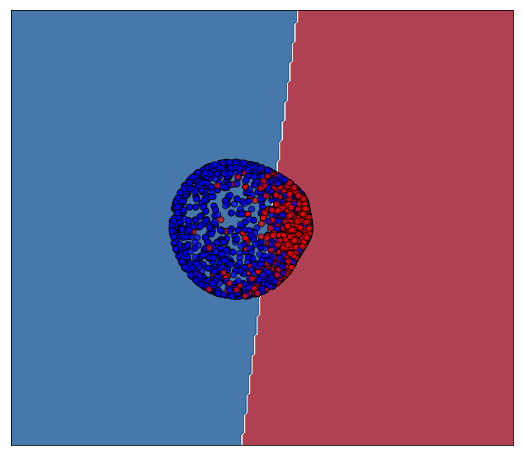

In [33]:
clf = LogisticRegression()
clf.fit(Xkpca_train_noise,Y_train_noise)

acc_test = clf.score(Xkpca_test_noise,Y_test_noise)
print("Test Accuracy = %f"%acc_test)
plot_classifier(clf,Xkpca_train_noise,Y_train_noise,Xkpca_test_noise,Y_test_noise,"tree")

Con el 30% de ruido se obtienen peores resultados utilizando Kernel PCA se puede deber a que en el nuevo espacio el las clases se comienzan a solapar en mayor medida en comparación al problema inicial. 

# Pregunta 2

In [26]:
dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])
df = df.drop("Unnamed: 0",axis=1)
print('\nSummary - dataframe completo:\n')
df.describe()


Summary - dataframe completo:



season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.960477    151.039033   
min        0.760000      0.000000      0.000000      0.000000      0.000000   
25%       16.665000     47.000000      7.001500      4.000000     36.000000   
50%       24.240000     62.000000     12.998000     17.000000    118.000000   
75%       31.060000     77.000000     16.997900     49.000000    222.000000   
max       45.455000    100.000000     56.996900    367.000000    886.000000   

              count          hour  
count  10886.000000  10886.000000  
mean     191.574132     11.541613  
std      181.144454      6.915838  
min        1.000000      0.000000  
25%       42.000000      6.000000  
50%      145.000000     12.000000  
75%      284.000000     18.000000  
max      977.000000     23.000000

In [ ]:
fig,ax  = plt.subplots(2,6, figsize=(20,8))
ax = ax.ravel()
for i,column in enumerate(df.drop("datetime",axis=1).columns):
    sns.distplot(df[column],ax=ax[i])
plt.show()

In [ ]:
def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

In [ ]:
Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed','hour']]
Ydf=df.loc[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

In [ ]:
#Creando Regression Tree
model = DecisionTreeRegressor(random_state=0)
model.fit(X_train,Y_train)

#Calculando Test Score
score_test = model.score(X_test,Y_test)
print("SCORE TEST=%f"%score_test)

#Calculando Kaggle Score para cada conjunto
Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test) #Deberia volver a entrenar el modelo con Train + Val para este

kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)

#Mostrando valores de kaggle score
print("KAGG EVAL TRAIN =%f"%kagg_train)
print("KAGG EVAL TEST =%f"%kagg_test)

#Plot de test vs predicción 
#deberia ser una recta en 45°
plt.plot(Y_test,Y_pred_test,'.')
plt.xlabel("y-test")
plt.ylabel("y-predicted")
plt.show()

In [ ]:
"""
Función para realizar una visualización interactiva del
score y plot y-real vs y-pred

"""
def interact_depth(data,  max_depth=20, interactive=True, preproc = None):
    X_train, Y_train, X_test, Y_test, X_val, Y_val = data
    model = DecisionTreeRegressor(random_state=0,max_depth=max_depth)
    model.fit(X_train,Y_train)
    Y_pred_val = model.predict(X_val)
    kagg_val = eval_bikemodel(Y_pred_val,Y_val) if preproc is None else  eval_bikemodel(preproc(Y_pred_val),Y_val)
    Y_pred_train = model.predict(X_train)

    kagg_train = eval_bikemodel(Y_pred_train,Y_train)if preproc is None else  eval_bikemodel(preproc(Y_pred_train),preproc(Y_train))
    
    #Solo si es interactivo muestra el plot y 
    #los kaggle score respectivos
    if interactive:
        fig,(ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(15,6))
        ax1.plot(Y_pred_val,Y_val,'.')
        ax1.set_xlabel("y-val")
        ax1.set_ylabel("y-predicted")
        ax1.set_title("Validation Set")
        
        Y_pred_test = model.predict(X_test)
        kagg_test = eval_bikemodel(Y_pred_test,Y_test)if preproc is None else  eval_bikemodel(preproc(Y_pred_test),Y_test)
        ax2.plot(Y_pred_test,Y_test,'.')
        ax2.set_xlabel("y-test")
        ax2.set_ylabel("y-predicted")        
        ax1.set_title("Test Set")
        
        plt.show()
        print("KAGG EVAL TRAIN =%f"%kagg_train)
        print("KAGG EVAL VAL =%f"%kagg_val)
        print("KAGG EVAL TEST =%f"%kagg_test)
    return kagg_train,kagg_val

In [ ]:
#Fitteando arboles con distinta profundidad
#maxima para luego seleccionar el mejor

limit_depth = 30
kagg_values_val = []
kagg_values_train = []
for max_depth in range(1,limit_depth+1):
    kagg_train,kagg_val = interact_depth((X_train, Y_train, X_test, Y_test, X_val, Y_val) ,max_depth, False)
    kagg_values_train.append(kagg_train)    
    kagg_values_val.append(kagg_val)

In [ ]:
#Graficando los resultados a diferentes profundidades maximaslimit_depth+1
plt.plot(list(range(1,limit_depth+1)), kagg_values_train)
plt.plot(list(range(1,limit_depth+1)), kagg_values_val)

plt.title("Validation Kaggle Score")
plt.ylabel("Kaggle Score")
plt.xlabel("Max Depth")
plt.legend(["Train", "Validation"])
plt.show()

best_depth = np.argmin(kagg_values_val)+1
print("Best Validation Depth:",best_depth)

Al seguir aumentando el `max_depth` se tiende a realizar overfitting de los datos por lo que el score sigue disminuyendo en el train pero en el conjunto de validación se mantiene constante hasta disminuye en algunos tramos.

In [ ]:
_= interact(interact_depth,data = fixed((X_train, Y_train, X_test, Y_test, X_val, Y_val)),max_depth=(1,limit_depth),interactive=fixed(True), preproc=fixed(None))

In [ ]:
df["day of week"] = pd.to_datetime(df.datetime).apply(lambda x: x.dayofweek)
Xdf=df.loc[:,['season','holiday','workingday','weather','temp','atemp',
'humidity','windspeed', "day of week"]]
Ydf=df.loc[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

In [ ]:
import sklearn.preprocessing as preproc
minmax = preproc.MinMaxScaler()
X_train_norm = minmax.fit_transform(X_train)
X_test_norm = minmax.transform(X_test)
X_val_norm = minmax.transform(X_val)

Y_train_sqrt = np.sqrt(Y_train)
data = X_train_norm, Y_train_sqrt, X_test_norm, Y_test, X_val_norm, Y_val

def inverse_sqrt(Y):
    return np.power(Y,2)

In [ ]:
limit_depth = 30
kagg_values_val = []
kagg_values_train = []
for max_depth in range(1,limit_depth+1):
    kagg_train,kagg_val = interact_depth(data ,max_depth, False,inverse_sqrt)
    kagg_values_train.append(kagg_train)    
    kagg_values_val.append(kagg_val)

In [ ]:
#Graficando los resultados a diferentes profundidades maximaslimit_depth+1
plt.plot(list(range(1,limit_depth+1)), kagg_values_train)
plt.plot(list(range(1,limit_depth+1)), kagg_values_val)

plt.title("Validation Kaggle Score")
plt.ylabel("Kaggle Score")
plt.xlabel("Max Depth")
plt.legend(["Train", "Validation"])
plt.show()

best_depth = np.argmin(kagg_values_val)+1
print("Best Validation Depth:",best_depth)

In [ ]:
_= interact(interact_depth,data = fixed(data),max_depth=(1,limit_depth),interactive=fixed(True), preproc=fixed(inverse_sqrt))